# **Gaussian Process** #

## **Importing Libraries and Loading Data**

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [53]:
#load data from inpute.data file
data = np.loadtxt('input.data', delimiter=' ')
X_train = data[:, 0].reshape(-1, 1)  # Training inputs (34x1)
y_train = data[:, 1]  # Training targets (34,)

## **Defining the Rational Quadratic Kernel**

In [54]:
def rational_quadratic_kernel(x1, x2, length_scale, alpha, sigma_f):
    """Computes the Rational Quadratic Kernel."""
    dist = np.sum((x1 - x2)**2, axis=-1)  # Squared Euclidean distance
    return sigma_f**2 * (1 + dist / (2 * alpha * length_scale**2)) ** -alpha


## **Computing the Covariance Matrix**

In [55]:
def compute_covariance_matrix(X1, X2, length_scale, alpha, sigma_f, noise=0.0):
    """Computes the covariance matrix with noise term."""
    n1, n2 = X1.shape[0], X2.shape[0]
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)
    if X1 is X2:  # Add noise only to diagonal for training data
        K += noise * np.eye(n1)
    return K

## **Gaussian Process Prediction**

In [56]:
def gp_predict(X_train, y_train, X_test, kernel_params, noise_variance):
    """Performs GP regression and returns the mean and variance."""
    length_scale, alpha, sigma_f = kernel_params
    # Compute the covariance matrices
    K = compute_covariance_matrix(X_train, X_train, length_scale, alpha, sigma_f, noise_variance)
    K_s = compute_covariance_matrix(X_train, X_test, length_scale, alpha, sigma_f)
    K_ss = compute_covariance_matrix(X_test, X_test, length_scale, alpha, sigma_f)
    
    # Compute the inverse of K
    K_inv = np.linalg.inv(K)
    
    # Predictive mean
    mu = K_s.T @ K_inv @ y_train
    
    # Predictive variance
    cov = K_ss - K_s.T @ K_inv @ K_s
    var = np.diag(cov)  # Extract diagonal for variances
    
    return mu, var


## **Negative Log-Likelihood Optimization**

In [57]:
def negative_log_likelihood(params, X_train, y_train, noise_variance):
    """Negative Marginal Log-Likelihood (NLL) function."""
    length_scale, alpha, sigma_f = params
    K = compute_covariance_matrix(X_train, X_train, length_scale, alpha, sigma_f, noise_variance)
    K_inv = np.linalg.inv(K)
    n = len(y_train)
    
    # NLL formula
    term1 = 0.5 * y_train.T @ K_inv @ y_train
    term2 = 0.5 * np.log(np.linalg.det(K))
    term3 = 0.5 * n * np.log(2 * np.pi)
    return term1 + term2 + term3

# Initial kernel parameters: length_scale, alpha, sigma_f
initial_params = [1.0, 1.0, 1.0]




In [61]:
# Optimize
optimized_params = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_train, y_train, 1 / 5),  # β = 5 -> noise_variance = 1/β
    bounds=((1e-3, None), (1e-3, None), (1e-3, None))  # Non-negative constraints
).x

print(optimized_params)

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


[  3.31317168 226.65466042   1.30838806]


## **Visualizations**

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


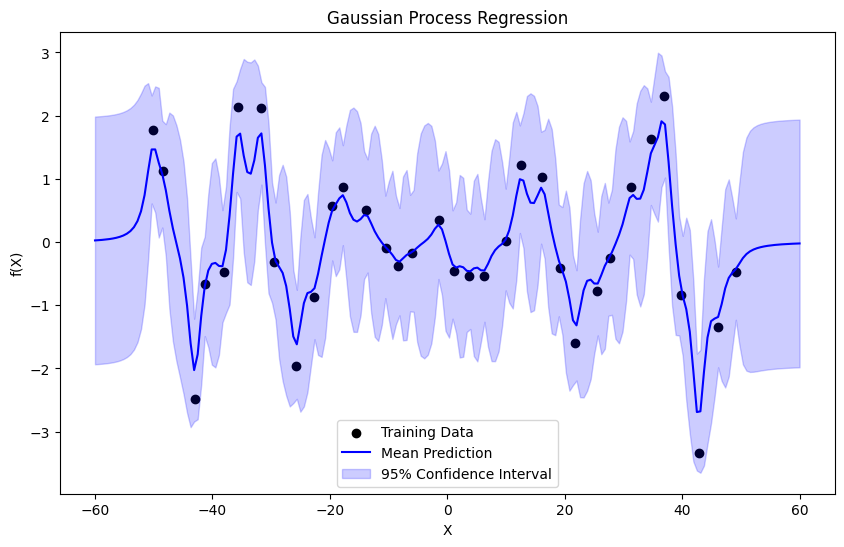

In [58]:
# Define test points
X_test = np.linspace(-60, 60, 200).reshape(-1, 1)

# Get predictions
mu, var = gp_predict(X_train, y_train, X_test, initial_params, 1 / 5)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='black', label='Training Data')  # Training points
plt.plot(X_test, mu, label='Mean Prediction', color='blue')  # Mean
plt.fill_between(
    X_test.flatten(),
    mu - 1.96 * np.sqrt(var),  # Lower bound
    mu + 1.96 * np.sqrt(var),  # Upper bound
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.title('Gaussian Process Regression')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


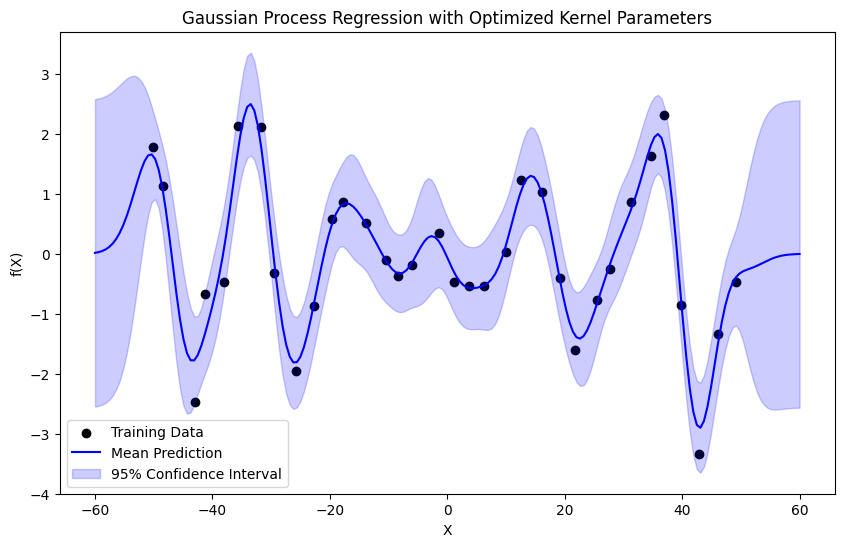

In [60]:
# Define test points
X_test = np.linspace(-60, 60, 200).reshape(-1, 1)

# Get predictions
mu, var = gp_predict(X_train, y_train, X_test, optimized_params, 1 / 5)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='black', label='Training Data')  # Training points
plt.plot(X_test, mu, label='Mean Prediction', color='blue')  # Mean
plt.fill_between(
    X_test.flatten(),
    mu - 1.96 * np.sqrt(var),  # Lower bound
    mu + 1.96 * np.sqrt(var),  # Upper bound
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.title('Gaussian Process Regression with Optimized Kernel Parameters')
plt.show()


## **Differenet Hyperparameters**

### **length scale**

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


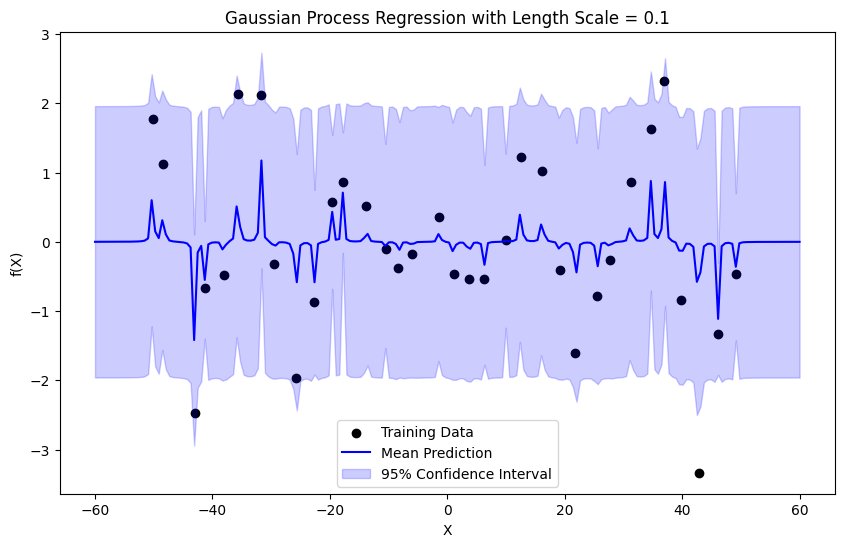

In [62]:
# test with different params of the kernel
# let's start by changing the length scale
length_scale = 0.1
alpha = 1.0
sigma_f = 1.0
params = [length_scale, alpha, sigma_f]

# Get predictions
mu, var = gp_predict(X_train, y_train, X_test, params, 1 / 5)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='black', label='Training Data')  # Training points
plt.plot(X_test, mu, label='Mean Prediction', color='blue')  # Mean
plt.fill_between(
    X_test.flatten(),
    mu - 1.96 * np.sqrt(var),  # Lower bound
    mu + 1.96 * np.sqrt(var),  # Upper bound
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.title('Gaussian Process Regression with Length Scale = 0.1')
plt.show()


### **alpha**

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


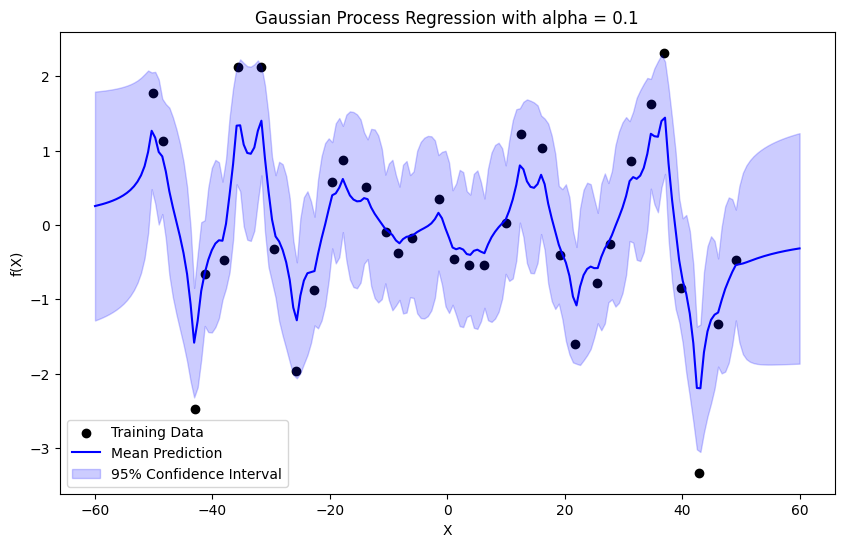

In [63]:
# let's change the alpha
length_scale = 1.0
alpha = 0.1
sigma_f = 1.0
params = [length_scale, alpha, sigma_f]

# Get predictions
mu, var = gp_predict(X_train, y_train, X_test, params, 1 / 5)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='black', label='Training Data')  # Training points
plt.plot(X_test, mu, label='Mean Prediction', color='blue')  # Mean
plt.fill_between(
    X_test.flatten(),
    mu - 1.96 * np.sqrt(var),  # Lower bound
    mu + 1.96 * np.sqrt(var),  # Upper bound
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.title('Gaussian Process Regression with alpha = 0.1')
plt.show()

### **sigmaf**

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


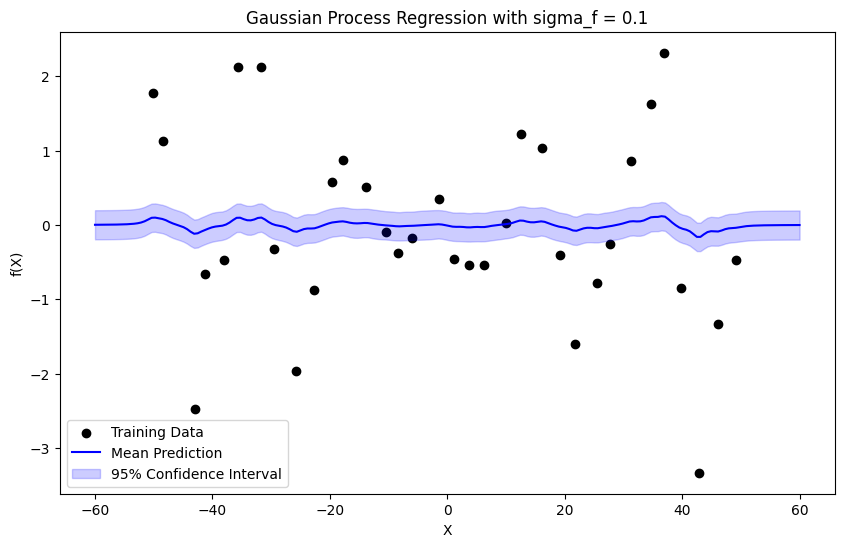

In [64]:
# let's change the sigma_f
length_scale = 1.0
alpha = 1.0
sigma_f = 0.1
params = [length_scale, alpha, sigma_f]

# Get predictions
mu, var = gp_predict(X_train, y_train, X_test, params, 1 / 5)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='black', label='Training Data')  # Training points
plt.plot(X_test, mu, label='Mean Prediction', color='blue')  # Mean
plt.fill_between(
    X_test.flatten(),
    mu - 1.96 * np.sqrt(var),  # Lower bound
    mu + 1.96 * np.sqrt(var),  # Upper bound
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.title('Gaussian Process Regression with sigma_f = 0.1')
plt.show()

### **Noise**

C:\Users\user\AppData\Local\Temp\ipykernel_4216\598069116.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rational_quadratic_kernel(X1[i:i+1], X2[j:j+1], length_scale, alpha, sigma_f)


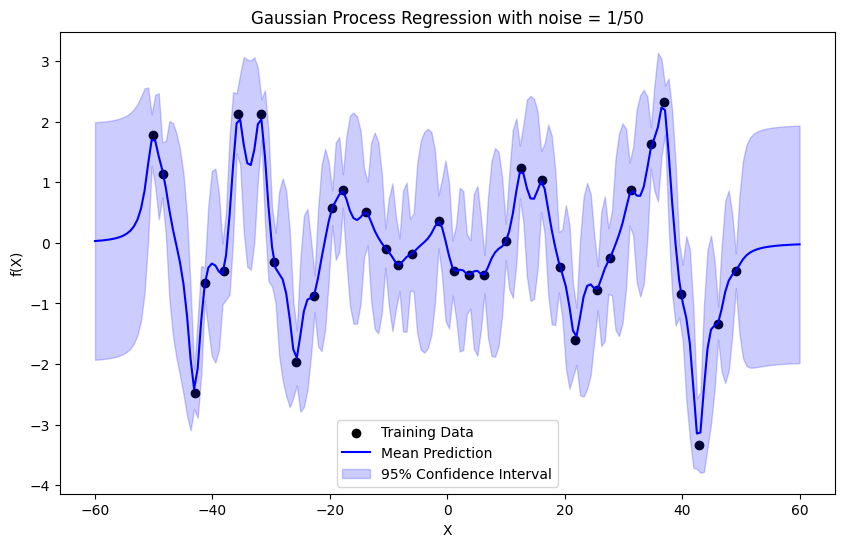

In [69]:
# let's change the noise variance
length_scale = 1.0
alpha = 1.0
sigma_f = 1.0
params = [length_scale, alpha, sigma_f]

# Get predictions
mu, var = gp_predict(X_train, y_train, X_test, params, 1/50)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='black', label='Training Data')  # Training points
plt.plot(X_test, mu, label='Mean Prediction', color='blue')  # Mean
plt.fill_between(
    X_test.flatten(),
    mu - 1.96 * np.sqrt(var),  # Lower bound
    mu + 1.96 * np.sqrt(var),  # Upper bound
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.title('Gaussian Process Regression with noise = 1/50')
plt.show()

# **SVM on Mnist**

## **Task 1**

### **Loading dataset**

In [45]:
import numpy as np
import pandas as pd
from libsvm.svmutil import svm_train, svm_predict, svm_save_model, svm_read_problem
import matplotlib.pyplot as plt
import csv
import itertools

In [46]:
def load_data(X_train_path, y_train_path, X_test_path, y_test_path):
    X_train = np.zeros((0, 784))
    y_train = []
    X_test = np.zeros((0, 784))
    y_test = []

    with open(X_train_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            X_train = np.vstack([X_train, np.array(row).astype(float)])
    with open(y_train_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            y_train.append(int(row[0]))
    with open(X_test_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            X_test = np.vstack([X_test, np.array(row).astype(float)])
    with open(y_test_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            y_test.append(int(row[0]))

    return X_train, y_train, X_test, y_test

In [79]:
X_train, y_train, X_test, y_test = load_data('X_train.csv', 'Y_train.csv', 'X_test.csv', 'Y_test.csv')

# Check shapes
print("Training data shape:", X_train.shape)
print("Training labels shape:", len(y_train))
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", len(y_test))

Training data shape: (5000, 784)
Training labels shape: 5000
Testing data shape: (2500, 784)
Testing labels shape: 2500


### **Training and evaluation function**

In [23]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, kernel_type, **kwargs):
    """
    Train and evaluate an SVM model using LIBSVM.
    :param X_train: Training data
    :param y_train: Training labels
    :param X_test: Testing data
    :param y_test: Testing labels
    :param kernel_type: Kernel type (linear: 0, polynomial: 1, RBF: 2)
    :param kwargs: Kernel-specific parameters
    """
    X_train = np.array(X_train).tolist()
    y_train = np.array(y_train).tolist()
    X_test = np.array(X_test).tolist()
    y_test = np.array(y_test).tolist()

    # Define kernel parameters
    kernel_params = f"-t {kernel_type} "
    
    # Add additional kernel parameters
    if kernel_type == 1:  # Polynomial kernel
        kernel_params += f"-d {kwargs.get('degree', 3)} -r {kwargs.get('coef0', 0)} "
    if kernel_type == 2:  # RBF kernel
        kernel_params += f"-g {kwargs.get('gamma', 1.0)} "
    
    # Add common parameters (C)
    kernel_params += f"-c {kwargs.get('C', 1.0)} "
    
    # Train the model
    model = svm_train(y_train, X_train, kernel_params)
    
    # Predict
    predictions, accuracy, _ = svm_predict(y_test, X_test, model)
    
    # Print results
    print(f"Accuracy: {accuracy[0]:.2f}%")
    return predictions, accuracy[0]


In [25]:
print("Linear Kernel:")
# Linear kernel
train_and_evaluate_svm(X_train, y_train, X_test, y_test, kernel_type=0)
print("=" * 50)
print("Polynomial Kernel:")
# Polynomial kernel
train_and_evaluate_svm(X_train, y_train, X_test, y_test, kernel_type=1, degree=3, coef0=1)
print("=" * 50)
print("RBF Kernel:")
# RBF kernel
train_and_evaluate_svm(X_train, y_train, X_test, y_test, kernel_type=2, gamma=0.1)

Linear Kernel:
Accuracy = 95.08% (2377/2500) (classification)
Accuracy: 95.08%
Polynomial Kernel:
Accuracy = 95.76% (2394/2500) (classification)
Accuracy: 95.76%
RBF Kernel:
Accuracy = 90.4% (2260/2500) (classification)
Accuracy: 90.40%


([3.0,
  3.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  3.0,
  3.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  3.0,
  1.0,
  3.0,
  1.0,
  3.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  3.0,
  1.0,
  3.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,

## **Task 2**

### **Grid search function**

In [32]:
def grid_search(X_train, y_train, X_test, y_test, kernel_type, param_grid):
    """
    Perform grid search for SVM parameters for polynomial and RBF kernels using LIBSVM.
    :param X_train: Training data
    :param y_train: Training labels
    :param X_test: Testing data
    :param y_test: Testing labels
    :param kernel_type: Kernel type (polynomial: 1, RBF: 2)
    :param param_grid: Dictionary of parameters to search
    :return: Best parameters and best accuracy
    """
    X_train = np.array(X_train).tolist()
    y_train = np.array(y_train).tolist()
    X_test = np.array(X_test).tolist()
    y_test = np.array(y_test).tolist()

    # Convert parameter grid to a list of parameter combinations
    param_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())

    best_params = None
    best_accuracy = 0

    for param_set in param_combinations:
        # Prepare parameters for LIBSVM
        params = dict(zip(param_names, param_set))
        kernel_params = f"-t {kernel_type} "

        if kernel_type == 1:  # Polynomial kernel
            kernel_params += f"-d {params.get('degree', 3)} -r {params.get('coef0', 0)} "
        elif kernel_type == 2:  # RBF kernel
            kernel_params += f"-g {params.get('gamma', 1.0)} "

        # Add regularization parameter C
        kernel_params += f"-c {params.get('C', 1.0)} "

        # Train and evaluate
        model = svm_train(y_train, X_train, kernel_params)
        _, accuracy, _ = svm_predict(y_test, X_test, model)

        # Update best parameters if accuracy improves
        if accuracy[0] > best_accuracy:
            best_accuracy = accuracy[0]
            best_params = params

        print(f"Params: {params}, Accuracy: {accuracy[0]:.2f}%")

    print(f"Best Parameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy:.2f}%")
    return best_params, best_accuracy





In [30]:
param_grid_poly = {
    'degree': [2, 3, 4],
    'coef0': [0, 1],
    'C': [0.1, 1, 10]
}

param_grid_rbf = {
    'gamma': [0.01, 0.1, 1],
    'C': [0.1, 1, 10]
}

In [33]:
print("Polynomial Kernel Grid Search:")
best_params_poly, best_acc_poly = grid_search(
    X_train, y_train, X_test, y_test,
    kernel_type=1,  # Polynomial kernel
    param_grid=param_grid_poly
)


Polynomial Kernel Grid Search:
Accuracy = 48.6% (1215/2500) (classification)
Params: {'degree': 2, 'coef0': 0, 'C': 0.1}, Accuracy: 48.60%
Accuracy = 88.24% (2206/2500) (classification)
Params: {'degree': 2, 'coef0': 0, 'C': 1}, Accuracy: 88.24%
Accuracy = 95.2% (2380/2500) (classification)
Params: {'degree': 2, 'coef0': 0, 'C': 10}, Accuracy: 95.20%
Accuracy = 93.12% (2328/2500) (classification)
Params: {'degree': 2, 'coef0': 1, 'C': 0.1}, Accuracy: 93.12%
Accuracy = 95.32% (2383/2500) (classification)
Params: {'degree': 2, 'coef0': 1, 'C': 1}, Accuracy: 95.32%
Accuracy = 96.28% (2407/2500) (classification)
Params: {'degree': 2, 'coef0': 1, 'C': 10}, Accuracy: 96.28%
Accuracy = 28.88% (722/2500) (classification)
Params: {'degree': 3, 'coef0': 0, 'C': 0.1}, Accuracy: 28.88%
Accuracy = 34.68% (867/2500) (classification)
Params: {'degree': 3, 'coef0': 0, 'C': 1}, Accuracy: 34.68%
Accuracy = 79.72% (1993/2500) (classification)
Params: {'degree': 3, 'coef0': 0, 'C': 10}, Accuracy: 79.72%
A

In [34]:
print("RBF Kernel Grid Search:")
best_params_rbf, best_acc_rbf = grid_search(
    X_train, y_train, X_test, y_test,
    kernel_type=2,  # RBF kernel
    param_grid=param_grid_rbf
)


RBF Kernel Grid Search:
Accuracy = 95.6% (2390/2500) (classification)
Params: {'gamma': 0.01, 'C': 0.1}, Accuracy: 95.60%
Accuracy = 97.52% (2438/2500) (classification)
Params: {'gamma': 0.01, 'C': 1}, Accuracy: 97.52%
Accuracy = 98.2% (2455/2500) (classification)
Params: {'gamma': 0.01, 'C': 10}, Accuracy: 98.20%
Accuracy = 50.88% (1272/2500) (classification)
Params: {'gamma': 0.1, 'C': 0.1}, Accuracy: 50.88%
Accuracy = 90.4% (2260/2500) (classification)
Params: {'gamma': 0.1, 'C': 1}, Accuracy: 90.40%
Accuracy = 91% (2275/2500) (classification)
Params: {'gamma': 0.1, 'C': 10}, Accuracy: 91.00%
Accuracy = 20.08% (502/2500) (classification)
Params: {'gamma': 1, 'C': 0.1}, Accuracy: 20.08%
Accuracy = 30.04% (751/2500) (classification)
Params: {'gamma': 1, 'C': 1}, Accuracy: 30.04%
Accuracy = 31.32% (783/2500) (classification)
Params: {'gamma': 1, 'C': 10}, Accuracy: 31.32%
Best Parameters: {'gamma': 0.01, 'C': 10}
Best Accuracy: 98.20%


## **Task 3**

In [94]:
def custom_kernel(x, z, gamma, alpha=0.5, beta=0.5):
    """
    Custom kernel: weighted combination of linear and RBF.
    :param x: First vector
    :param z: Second vector
    :param gamma: RBF kernel parameter
    :param alpha: Weight for linear kernel
    :param beta: Weight for RBF kernel
    :return: Combined kernel value
    """
    linear = np.dot(x, z)
    rbf = np.exp(-gamma * np.linalg.norm(x - z) ** 2)
    return alpha * linear + beta * rbf


def compute_kernel_matrix(X, Z, gamma, alpha=0.5, beta=0.5):
    """
    Compute the precomputed kernel matrix.
    :param X: First dataset (e.g., training set)
    :param Z: Second dataset (e.g., training or testing set)
    :param gamma: RBF kernel parameter
    :param alpha: Weight for linear kernel
    :param beta: Weight for RBF kernel
    :return: Kernel matrix
    """
    n_samples = X.shape[0]
    m_samples = Z.shape[0]
    kernel_matrix = np.zeros((n_samples, m_samples))

    for i in range(n_samples):
        for j in range(m_samples):
            kernel_matrix[i, j] = custom_kernel(X[i], Z[j], gamma, alpha, beta)

    return kernel_matrix


def format_for_libsvm_kernel(kernel_matrix):
    """
    Convert a kernel matrix into the format required by LIBSVM
    :param kernel_matrix: Precomputed kernel matrix
    :return: Kernel matrix in LIBSVM's required format (list of lists of tuples)
    """
    n_samples = kernel_matrix.shape[0]
    formatted_kernel = []

    for i in range(n_samples):
        row = [(j + 1, kernel_matrix[i, j]) for j in range(n_samples)]
        formatted_kernel.append(row)

    return formatted_kernel


def train_svm_with_custom_kernel(y_train, train_kernel, C=1.0):
    """
    Train an SVM model with a precomputed kernel.
    :param y_train: Training labels
    :param train_kernel: Precomputed training kernel matrix
    :param C: Regularization parameter
    """
    # Train the model with precomputed kernel (-t 4)
    model = svm_train(y_train, train_kernel, f"-t 4 -c {C}")
    return model


def test_svm_with_custom_kernel(y_test, test_kernel, model):
    """
    Test an SVM model with a precomputed kernel.
    :param y_test: Test labels
    :param test_kernel: Precomputed test kernel matrix
    :param model: Trained SVM model
    """
    predictions, accuracy, _ = svm_predict(y_test, test_kernel, model)
    print(f"Custom Kernel Accuracy: {accuracy[0]:.2f}%")
    return predictions, accuracy[0]


# Parameters for the custom kernel
gamma = 0.1
alpha, beta = 0.5, 0.5

# Compute precomputed kernel matrices
train_kernel_matrix = compute_kernel_matrix(X_train, X_train, gamma, alpha, beta)
test_kernel_matrix = compute_kernel_matrix(X_test, X_train, gamma, alpha, beta)

# Train the model using the correctly formatted kernel matrix
train_kernel_libsvm = format_for_libsvm_kernel(train_kernel_matrix)

# Train the model
model = svm_train(y_train, train_kernel_libsvm, '-t 4 -c 1.0')

# Test the model
test_kernel_libsvm = format_for_libsvm_kernel(test_kernel_matrix)
predictions, accuracy, _ = svm_predict(y_test, test_kernel_libsvm, model)


TypeError: must be real number, not tuple